# Проект по сервису для чтения книг по подписке

## Введение

Исследование **направлено на** разработку предложения нового продукта в сервисе для чтения книг по подписке. Данное исследование **построено на данных** с информацией о книгах, издательствах, авторах, а также на пользовательских обзорах книг.

**Потребность в исследовании** связана с возрастающим спросом на приложения для чтения книг, который был обусловлен коронавирусом и связанными с ним ограничениями. Всё это изменило предпочтения в досуге людей, и создало большое число таких приложений и сервисов.

Исследование состоит из **следующих этапов**:
1. [Обзор и описание исходных данных](#step_1):
    * [Импорт библиотек и подключение к базе данных](#step_1.1);
    * [Данные о книгах](#step_1.2);
    * [Данные об авторах](#step_1.3);
    * [Данные об издательствах](#step_1.4);
    * [Пользовательские оценки книг](#step_1.5);
    * [Пользовательские обзоры на книги](#step_1.6);
    * [Вывод](#step_1.7).
2. [Анализ данных](#step_2):
    * [Число книг, вышедших с 2000 года](#step_2.1);
    * [Количество обзоров и средняя оценка](#step_2.2);
    * [Издательство, выпустившее наибольшее число книг](#step_2.3);
    * [Автор с самой высокой средней оценкой книг](#step_2.4);
    * [Среднее количество обзоров от активных пользователей](#step_2.5);
    * [Вывод](#step_2.6).
3. [Общий вывод](#step_3);
4. [Рекомендации](#step_4).

**Результатом исследования** являются рекомендации по предложению нового продукта в сервисе для чтения книг по подписке.

## Этап 1. Обзор и описание исходных данных <a id='step_1'></a>

### Импорт библиотек и подключение к базе данных <a id='step_1.1'></a>

In [1]:
# Импортируем библиотеки 
import pandas as pd 
from sqlalchemy import create_engine
pd.options.display.max_colwidth = 150

Подготовим подключение к базе.

In [2]:
# Устанавливаем параметры
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль 
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', 
             'port': 6432, # порт подключения 
             'db': 'data-analyst-final-project-db'} # название базы данных 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'], 
                                                         db_config['pwd'], 
                                                         db_config['host'], 
                                                         db_config['port'], 
                                                         db_config['db']) 
# Сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

Запишем функцию выполнения SQL-запроса.

In [3]:
def read_sql(query):
    result = pd.io.sql.read_sql(query, con = engine)
    return result

### Данные о книгах <a id='step_1.2'></a>

Откроем таблицу `books` и изучим, какую информацию она в себе содержит.

In [4]:
books = '''
            SELECT *
            FROM books
            LIMIT 5;
        '''
read_sql(books)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope #1),322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before Columbus,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


Посчитаем, чему равен размер таблицы.

In [5]:
books_len = '''
            SELECT
                COUNT (*) AS length
            FROM books;
            '''
read_sql(books_len)

,length
0,1000


Таблица `books` состоит из 1 000 строк и 6 столбцов. Рассмотрим, какие данные содержит в себе каждый из столбцов.
* `book_id` — идентификатор книги;
* `author_id` — идентификатор автора;
* `title` — название книги;
* `num_pages` — количество страниц;
* `publication_date` — дата публикации книги;
* `publisher_id` — идентификатор издателя.

Из 1 000 значений посчитаем, сколько уникальных значений в текстовых и идентификационных столбцах, и в каком диапазоне ранжируются номера страниц и даты.

In [6]:
books_info = '''
            SELECT
                COUNT (DISTINCT b.book_id) AS book_id_uniq_cnt,
                COUNT (DISTINCT b.author_id) AS author_id_uniq_cnt,
                COUNT (DISTINCT b.title) AS title_uniq_cnt,
                MIN (b.num_pages) AS pages_min,
                MAX (b.num_pages) AS pages_max,
                MIN (b.publication_date) AS date_min,
                MAX (b.publication_date) AS date_max,
                COUNT (DISTINCT b.publisher_id) AS publisher_id_uniq_cnt
            FROM books b;
            '''
read_sql(books_info)

,book_id_uniq_cnt,author_id_uniq_cnt,title_uniq_cnt,pages_min,pages_max,date_min,date_max,publisher_id_uniq_cnt
0,1000,636,999,14,2690,1952-12-01,2020-03-31,340


В таблице представлена 1 000 уникальных книг под авторством 636 авторов. При этом две книги имеют одинаковые названия, остальные названия не повторяются. Число страниц в книгах варьируется от 14 до 2 690 страниц; а даты издания - с 1 декабря 1952 года по 31 марта 2020 года. Книги, информацией о которых мы обладаем, были изданы 340 разными издательствами.

Проверим, что книги с повторяющимся названием имеют разные характеристики (автора, число страниц, дату публикации или издательство); и не являются дубликатами.

In [7]:
books_title_duplicated = '''
                        SELECT *
                        FROM books
                        WHERE
                            title = (SELECT
                                        Sub.title
                                    FROM
                                        (SELECT
                                            b.title,
                                            COUNT(*) AS title_cnt
                                        FROM books b
                                        GROUP BY title
                                        HAVING COUNT(*)>1) AS Sub);
                        '''
read_sql(books_title_duplicated)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,426,39,Memoirs of a Geisha,434,2005-11-15,241
1,427,39,Memoirs of a Geisha,503,2005-11-22,311


Книги с повторяющимся названием не являются дубликатами, поскольку хоть и написаны тем же автором, имеют разное число страниц, дату выхода и название издательства.

Также проверим, что в данных нет пропусков.

In [8]:
books_null = '''
            SELECT *
            FROM books b
            WHERE (b.author_id IS NULL) OR (b.num_pages IS NULL) OR (b.publication_date IS NULL) OR (b.publisher_id IS NULL);
            '''
read_sql(books_null)

,book_id,author_id,title,num_pages,publication_date,publisher_id


Пропусков в таблице `books` нет.

### Данные об авторах <a id='step_1.3'></a>

Откроем таблицу `authors` и изучим, какую информацию она в себе содержит.

In [9]:
authors = '''
            SELECT *
            FROM authors
            LIMIT 5;
            '''
read_sql(authors)

,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd


Посчитаем, чему равен размер таблицы.

In [10]:
authors_len = '''
            SELECT
                COUNT (*) AS length
            FROM authors;
            '''
read_sql(authors_len)

,length
0,636


Таблица `authors` состоит из 636 строк и 2 столбцов. Рассмотрим, какие данные содержит в себе каждый из столбцов.
* `author_id` — идентификатор автора;
* `author` — имя автора.

Из 636 значений посчитаем, сколько уникальных значений содержится в столбцах.

In [11]:
authors_info = '''
                SELECT
                    COUNT (DISTINCT a.author_id) AS author_id_uniq_cnt,
                    COUNT (DISTINCT a.author) AS author_uniq_cnt
                FROM authors a;
                '''
read_sql(authors_info)

,author_id_uniq_cnt,author_uniq_cnt
0,636,636


Все значения в таблице `authors` уникальны: соответственно, у нас имеется информация о 636 авторах. Дубликатов и пропусков в таблице нет.

### Данные об издательствах <a id='step_1.4'></a>

Откроем таблицу `publishers` и изучим, какую информацию она в себе содержит.

In [12]:
publishers = '''
            SELECT *
            FROM publishers
            LIMIT 5;
            '''
read_sql(publishers)

,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


Посчитаем, чему равен размер таблицы.

In [13]:
publishers_len = '''
                SELECT
                    COUNT (*) AS length
                FROM publishers;
                '''
read_sql(publishers_len)

,length
0,340


Таблица `publishers` состоит из 340 строк и 2 столбцов. Рассмотрим, какие данные содержит в себе каждый из столбцов.
* `publisher_id` — идентификатор издательства;
* `publisher` — название издательства.

Из 340 значений посчитаем, сколько уникальных значений содержится в столбцах.

In [14]:
publishers_info = '''
                    SELECT
                        COUNT (DISTINCT p.publisher_id) AS publisher_id_uniq_cnt,
                        COUNT (DISTINCT p.publisher) AS publisher_uniq_cnt
                    FROM publishers p;
                    '''
read_sql(publishers_info)

,publisher_id_uniq_cnt,publisher_uniq_cnt
0,340,340


Все значения в таблице `publishers` уникальны: соответственно, у нас имеется информация о 340 издательствах. Дубликатов и пропусков в таблице нет.

### Пользовательские оценки книг <a id='step_1.5'></a>

Откроем таблицу `ratings` и изучим, какую информацию она в себе содержит.

In [15]:
ratings = '''
            SELECT *
            FROM ratings
            LIMIT 5;
            '''
read_sql(ratings)

,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


Посчитаем, чему равен размер таблицы.

In [16]:
ratings_len = '''
                SELECT
                    COUNT (*) AS length
                FROM ratings;
                '''
read_sql(ratings_len)

,length
0,6456


Таблица `ratings` состоит из 6 456 строк и 4 столбцов. Рассмотрим, какие данные содержит в себе каждый из столбцов.
* `rating_id` — идентификатор оценки;
* `book_id` — идентификатор книги;
* `username` — имя пользователя, оставившего оценку;
* `rating` — оценка книги.

Из 6 456 значений посчитаем, сколько уникальных значений в текстовых и идентификационных столбцах, и в каком диапазоне ранжируется оценка книги.

In [17]:
ratings_info = '''
                SELECT
                    COUNT (DISTINCT rat.rating_id) AS rating_id_uniq_cnt,
                    COUNT (DISTINCT rat.book_id) AS book_id_uniq_cnt,
                    COUNT (DISTINCT rat.username) AS username_uniq_cnt,
                    MIN (rat.rating) AS rating_min,
                    MAX (rat.rating) AS rating_max
                FROM ratings rat;
                '''
read_sql(ratings_info)

,rating_id_uniq_cnt,book_id_uniq_cnt,username_uniq_cnt,rating_min,rating_max
0,6456,1000,160,1,5


Имеется информация об оценке 1 000 книг 160-тью пользователями. При этом оценка книги варьируется от 1 до 5 баллов. Все книги в совокупности были оценены 6 456 раз.

Также проверим, что в данных нет пропусков.

In [18]:
ratings_null = '''
                SELECT *
                FROM ratings
                WHERE (book_id IS NULL) OR (username IS NULL) OR (rating IS NULL);
                '''
read_sql(ratings_null)

,rating_id,book_id,username,rating


Пропусков в таблице `ratings` нет.

### Пользовательские обзоры на книги <a id='step_1.6'></a>

Откроем таблицу `reviews` и изучим, какую информацию она в себе содержит.

In [19]:
reviews = '''
            SELECT *
            FROM reviews
            LIMIT 5;
            '''
read_sql(reviews)

,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. Over provide race technology continue these.
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Among admit investment argue security.
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but person sport treatment industry. Kitchen decision deep the. Social party body the.
3,4,3,johnsonamanda,Finally month interesting blue could nature cultural bit. Prepare beat finish grow that smile teach. Dream me play near.
4,5,3,scotttamara,Nation purpose heavy give wait song will. List dinner another whole positive radio fast. Music staff many green.


Посчитаем, чему равен размер таблицы.

In [20]:
reviews_len = '''
                SELECT
                    COUNT (*) AS length
                FROM reviews;
                '''
read_sql(reviews_len)

,length
0,2793


Таблица `reviews` состоит из 2 793 строк и 4 столбцов. Рассмотрим, какие данные содержит в себе каждый из столбцов.
* `review_id` — идентификатор обзора;
* `book_id` — идентификатор книги;
* `username` — имя пользователя, написавшего обзор;
* `text` — текст обзора.

Из 2 793 значений посчитаем, сколько уникальных значений в текстовых и идентификационных столбцах.

In [21]:
reviews_info = '''
                SELECT
                    COUNT (DISTINCT rev.review_id) AS review_id_uniq_cnt,
                    COUNT (DISTINCT rev.book_id) AS book_id_uniq_cnt,
                    COUNT (DISTINCT rev.username) AS username_uniq_cnt,
                    COUNT (DISTINCT rev.text) AS text_uniq_cnt
                FROM reviews rev;
                '''
read_sql(reviews_info)

,review_id_uniq_cnt,book_id_uniq_cnt,username_uniq_cnt,text_uniq_cnt
0,2793,994,160,2793


У нас имеется 2 793 уникальных обзора на 994 книги от 160 пользователей. Отметим, что не на все имеющиеся в базе данных книги есть отзывы.

### Вывод <a id='step_1.7'></a>

Имеется информация о книгах, издательствах, авторах, а также на пользовательских обзорах книг. Связь между таблицами с данными отражена на схеме:

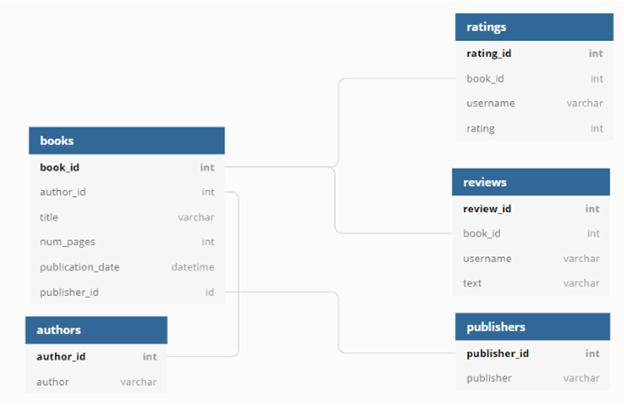

В данных встречается 1 000 уникальных книг под авторством 636 авторов. При этом две книги имеют одинаковые названия, остальные названия не повторяются. Однако, книги с повторяющимся названием не являются дубликатами, поскольку хоть и написаны тем же автором, имеют разное число страниц, дату выхода и название издательства. Число страниц в книгах варьируется от 14 до 2 690 страниц; а даты издания - с 1 декабря 1952 года по 31 марта 2020 года.

Книги, информацией о которых мы обладаем, были изданы 340 разными издательствами. Все 1 000 книги были оценены 160-тью разными пользователями. Некоторые пользователи оценили несколько книг. При этом пользователи написали обзор на 994 книги, в совокупности сделав 2 793 обзора. Оценка каждой книги варьируется от 1 до 5 баллов. Все книги в совокупности были оценены 6 456 раз.

## Этап 2. Анализ данных <a id='step_2'></a>

### Число книг, вышедших с 2000 года <a id='step_2.1'></a>

Рассчитаем, сколько книг вышло после 1 января 2000 года.

In [22]:
books_after_2000 = '''
                    SELECT
                        COUNT (*) AS books_after_2000
                    FROM books b
                    WHERE
                        b.publication_date >= '2000-01-01';
                    '''
read_sql(books_after_2000)

,books_after_2000
0,821


С 1 января 2000 года вышла 821 книга из представленных 1 000.

### Количество обзоров и средняя оценка <a id='step_2.2'></a>

In [23]:
books_reviews_and_avg_rating = '''
                                SELECT
                                    b.book_id AS book_id,
                                    b.title AS book_title,
                                    Sub_rev.reviews_cnt AS reviews_cnt,
                                    Sub_rat.rating_avg AS rating_avg
                                FROM
                                    books b
                                LEFT JOIN
                                        (SELECT
                                            rev.book_id,
                                            COUNT(rev.review_id) AS reviews_cnt
                                        FROM
                                            reviews rev
                                        GROUP BY
                                            rev.book_id) AS Sub_rev
                                    ON Sub_rev.book_id = b.book_id
                                LEFT JOIN 
                                        (SELECT
                                            rat.book_id,
                                            AVG(rat.rating) AS rating_avg
                                        FROM
                                            ratings rat
                                        GROUP BY
                                            rat.book_id) AS Sub_rat
                                    ON Sub_rat.book_id = b.book_id
                                WHERE Sub_rev.reviews_cnt IS NOT NULL
                                GROUP BY
                                    b.book_id,
                                    Sub_rev.reviews_cnt,
                                    Sub_rat.rating_avg
                                ORDER BY
                                    Sub_rev.reviews_cnt DESC;
                                '''
read_sql(books_reviews_and_avg_rating)

,book_id,book_title,reviews_cnt,rating_avg
0,948,Twilight (Twilight #1),7,3.662500
1,207,Eat Pray Love,6,3.395833
2,299,Harry Potter and the Chamber of Secrets (Harry Potter #2),6,4.287500
3,302,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),6,4.414634
4,497,Outlander (Outlander #1),6,4.125000
...,...,...,...,...
989,872,The Social Contract,1,3.500000
990,930,To Green Angel Tower (Memory Sorrow and Thorn #3),1,4.500000
991,943,Tsubasa: RESERVoir CHRoNiCLE Vol. 1,1,2.500000
992,980,Wicked: The Grimmerie,1,3.500000


Самое большое количество обзоров на первую книгу "Сумерки" (7 обзоров и средний рейтинг 3,66), книгу "Ешь, молись, люби" (6 обзоров и средний рейтинг 3,39), 2-я и 3-я книги о Гарри Поттере (6 обзоров на каждую и средний рейтинг 4,29 и 4,41, соответственно) и книга "Чужестранка" (6 обзоров и оценка 4,13).

"Пятёрка" книг, на которые имеется всего один обзор: "The Social Contract" (рейтинг 3,5), "To Green Angel Tower (Memory Sorrow and Thorn #3)" (рейтинг 4,5), "Tsubasa: RESERVoir CHRoNiCLE Vol. 1" (рейтинг 2,5), "Wicked: The Grimmerie" (рейтинг 3,5) и книга "Winter Prey (Lucas Davenport #5)" (рейтинг 4,5).

Таким образом, даже книги, на которые обзоров мало, могут иметь более высокую оценку, чем книги с большим количеством отзывов. Это может быть связано с тем, что отзыв оставляют либо те, кого книга очень сильно впечатлила, либо те, кому совсем не понравилась (с преимуществом вторых).

In [24]:
books_reviews_and_avg_rating = '''
                                SELECT
                                    b.book_id AS book_id,
                                    b.title AS book_title,
                                    Sub_rev.reviews_cnt AS reviews_cnt,
                                    Sub_rat.rating_avg AS rating_avg
                                FROM
                                    books b
                                LEFT JOIN
                                        (SELECT
                                            rev.book_id,
                                            COUNT(rev.review_id) AS reviews_cnt
                                        FROM
                                            reviews rev
                                        GROUP BY
                                            rev.book_id) AS Sub_rev
                                    ON Sub_rev.book_id = b.book_id
                                LEFT JOIN 
                                        (SELECT
                                            rat.book_id,
                                            AVG(rat.rating) AS rating_avg
                                        FROM
                                            ratings rat
                                        GROUP BY
                                            rat.book_id) AS Sub_rat
                                    ON Sub_rat.book_id = b.book_id
                                WHERE Sub_rev.reviews_cnt IS NOT NULL
                                GROUP BY
                                    b.book_id,
                                    Sub_rev.reviews_cnt,
                                    Sub_rat.rating_avg
                                ORDER BY
                                    Sub_rat.rating_avg DESC;
                                '''
read_sql(books_reviews_and_avg_rating)

,book_id,book_title,reviews_cnt,rating_avg
0,17,A Dirty Job (Grim Reaper #1),4,5.00
1,20,A Fistful of Charms (The Hollows #4),2,5.00
2,55,A Woman of Substance (Emma Harte Saga #1),2,5.00
3,57,Act of Treason (Mitch Rapp #9),2,5.00
4,62,Alas Babylon,2,5.00
...,...,...,...,...
989,915,The World Is Flat: A Brief History of the Twenty-first Century,3,2.25
990,202,Drowning Ruth,3,2.00
991,316,His Excellency: George Washington,2,2.00
992,371,Junky,2,2.00


Среди книг с наибольшим рейтингом встречаются такие как "A Dirty Job (Grim Reaper #1)" (4 обзора), "A Fistful of Charms (The Hollows #4)" (2 обзора), "A Woman of Substance (Emma Harte Saga #1)" (2 обзора), "Act of Treason (Mitch Rapp #9)" (2 обзора), "Alas Babylon" (2 обзора).

Книги с наименьшим рейтингом: "The World Is Flat: A Brief History of the Twenty-first Century" (3 обзора, оценка 2,25), "Drowning Ruth" (3 обзора, оценка 2), "His Excellency: George Washington" (2 обзора, оценка 2), "Junky" (2 обзоров, оценка 2) и "Harvesting the Heart" (2 обзора, самая низкая средняя оценка 1,5 балла).

Соответственно, наблюдаем следующую тенденцию. Больше всего обзоров имеют (и, возможно, больше всего читают) те книги, которые популярны - например, из-за экранизации. Но поскольку оценивает их большое число людей с разными вкусами, средние оценки у них не самые высокие. В то же время высокие оценки могут иметь совсем непопулярные книги, однако это не говорит о причинно-следственной связи, так как и низкие оценки могут иметь совсем непопулярные книги, на которые мало развёрнутых отзывов.

### Издательство, выпустившее наибольшее число книг <a id='step_2.3'></a>

Определим издательство, которое выпустило наибольшее число книг. При этом, чтобы исключить из анализа брошюры, возьмём книги толще 50 страниц.

In [25]:
publishers_top_num_books = '''
                            SELECT
                                p.publisher AS publisher_name,
                                COUNT(Sub_b.book_id) AS books_cnt
                            FROM
                                publishers p
                            LEFT JOIN (SELECT *
                                        FROM
                                            books b
                                        WHERE
                                            b.num_pages > 50) AS Sub_b
                                ON Sub_b.publisher_id = p.publisher_id
                            GROUP BY
                                p.publisher
                            ORDER BY
                                COUNT(Sub_b.book_id) DESC
                            LIMIT 5;
                            '''
read_sql(publishers_top_num_books)

,publisher_name,books_cnt
0,Penguin Books,42
1,Vintage,31
2,Grand Central Publishing,25
3,Penguin Classics,24
4,Bantam,19


TOP-5 издательств по количеству изданных книг: Penguin Books (42 книги), Vintage (31 книга), Grand Central Publishing (25 книг), Penguin Classics (24 книги) и Bantam (19 книг).

### Автор с самой высокой средней оценкой книг <a id='step_2.4'></a>

Определим автора с самой высокой средней оценкой книг для книг с 50 и более оценками.

In [26]:
authors_top_avg_rating = '''
                            SELECT
                                a.author AS author_name,
                                AVG(Sub_rat.rating_avg) AS rating_avg                                
                            FROM
                                authors a
                            RIGHT JOIN
                                    (SELECT
                                        rat.book_id AS book_id,
                                        b.author_id AS author_id,
                                        COUNT(rat.rating_id) AS ratings_num,
                                        AVG(rat.rating) AS rating_avg
                                    FROM
                                        ratings rat
                                    LEFT JOIN
                                        books b ON b.book_id = rat.book_id
                                    GROUP BY
                                        rat.book_id,
                                        b.author_id
                                    HAVING
                                        COUNT(rat.rating_id) >= 50) AS Sub_rat
                                ON a.author_id = Sub_rat.author_id
                            GROUP BY
                                a.author
                            ORDER BY
                                AVG(Sub_rat.rating_avg) DESC
                            LIMIT 5;
                            '''
read_sql(authors_top_avg_rating)

,author_name,rating_avg
0,J.K. Rowling/Mary GrandPré,4.283844
1,Markus Zusak/Cao Xuân Việt Khương,4.264151
2,J.R.R. Tolkien,4.258446
3,Louisa May Alcott,4.192308
4,Rick Riordan,4.080645


У нас имеется два автора, написавших книгу в соавторстве, с самой высокой средней оценкой книги в 4,284 балла - это J.K. Rowling и Mary GrandPré. Вывод верен для выборки из книг, имеющих свыше 50 оценок.

### Среднее количество обзоров от активных пользователей <a id='step_2.5'></a>

Рассчитаем среднее количество обзоров от активных пользователей. Под активными пользователями подразумеваем тех, которые поставили больше 50 оценок.

In [27]:
users_avg_reviews = '''
                    SELECT
                        rev.username AS username,
                        COUNT(rev.review_id) AS reviews_avg
                    FROM
                        reviews rev
                    WHERE
                        rev.username IN
                                    (SELECT
                                        Sub_rat.username
                                    FROM
                                        (SELECT
                                            rat.username AS username,
                                            COUNT(rat.rating_id) AS ratings_num
                                        FROM
                                            ratings rat
                                        GROUP BY
                                            rat.username
                                        HAVING
                                            COUNT(rat.rating_id) >= 50) AS Sub_rat)
                    GROUP BY
                        rev.username
                    ORDER BY
                        COUNT(rev.review_id) DESC;
                    '''
read_sql(users_avg_reviews)

,username,reviews_avg
0,sfitzgerald,28
1,martinadam,27
2,lesliegibbs,26
3,richard89,26
4,jennifermiller,25
5,shermannatalie,24
6,vanessagardner,22
7,paul88,22
8,xdavis,18


In [28]:
users_avg_reviews = '''
                    SELECT
                        AVG(Sub_rev.reviews_avg) AS users_avg_reviews
                    FROM
                        (SELECT
                            rev.username AS username,
                            COUNT(rev.review_id) AS reviews_avg
                        FROM
                            reviews rev
                        WHERE
                            rev.username IN
                                            (SELECT
                                                Sub_rat.username
                                            FROM
                                                (SELECT
                                                    rat.username AS username,
                                                    COUNT(rat.rating_id) AS ratings_num
                                                FROM
                                                    ratings rat
                                                GROUP BY
                                                    rat.username
                                                HAVING
                                                    COUNT(rat.rating_id) > 50) AS Sub_rat)
                        GROUP BY
                            rev.username) AS Sub_rev;
                    '''
read_sql(users_avg_reviews)

,users_avg_reviews
0,24.333333


У нас имеется 9 пользователей, являющихся активными (более 50 обзоров книг): это sfitzgerald (c 28 обзорами), martinadam (с 27 обзорами), lesliegibbs и richard89 (каждый с 26 обзорами), jennifermiller (с 25 обзорами), shermannatalie (с 24 обзорами), vanessagardner и paul88 (каждый с 22 обзорами) и xdavis (с 18 обзорами книг).

Таким образом, среднее число обзоров книг для самых активных пользователей составляет около 24 обзоров.

### Вывод <a id='step_2.6'></a>

Анализ данных позволил сделать **следующие выводы**.

**С 1 января 2000 года вышла 821 книга** из представленных 1 000. **Самое большое количество обзоров** на первую книгу "Сумерки" (7 обзоров и средний рейтинг 3,66), книгу "Ешь, молись, люби" (6 обзоров и средний рейтинг 3,39), 2-я и 3-я книги о Гарри Поттере (6 обзоров на каждую и средний рейтинг 4,29 и 4,41, соответственно) и книга "Чужестранка" (6 обзоров и оценка 4,13). **"Пятёрка" книг, на которые имеется всего один обзор**: "The Social Contract" (рейтинг 3,5), "To Green Angel Tower (Memory Sorrow and Thorn #3)" (рейтинг 4,5), "Tsubasa: RESERVoir CHRoNiCLE Vol. 1" (рейтинг 2,5), "Wicked: The Grimmerie" (рейтинг 3,5) и книга "Winter Prey (Lucas Davenport #5)" (рейтинг 4,5). Таким образом, даже книги, на которые обзоров мало, могут иметь более высокую оценку, чем книги с большим количеством отзывов. Это может быть связано с тем, что отзыв оставляют либо те, кого книга очень сильно впечатлила, либо те, кому совсем не понравилась (с преимуществом вторых).

Среди **книг с наибольшим рейтингом** встречаются такие как "A Dirty Job (Grim Reaper #1)" (4 обзора), "A Fistful of Charms (The Hollows #4)" (2 обзора), "A Woman of Substance (Emma Harte Saga #1)" (2 обзора), "Act of Treason (Mitch Rapp #9)" (2 обзора), "Alas Babylon" (2 обзора). **Книги с наименьшим рейтингом**: "The World Is Flat: A Brief History of the Twenty-first Century" (3 обзора, оценка 2,25), "Drowning Ruth" (3 обзора, оценка 2), "His Excellency: George Washington" (2 обзора, оценка 2), "Junky" (2 обзоров, оценка 2) и "Harvesting the Heart" (2 обзора, самая низкая средняя оценка 1,5 балла). Соответственно, наблюдаем следующую тенденцию. Больше всего обзоров имеют (и, возможно, больше всего читают) те книги, которые популярны - например, из-за экранизации. Но поскольку оценивает их большое число людей с разными вкусами, средние оценки у них не самые высокие. В то же время высокие оценки могут иметь совсем непопулярные книги, однако это не говорит о причинно-следственной связи, так как и низкие оценки могут иметь совсем непопулярные книги, на которые мало развёрнутых отзывов.

**TOP-5 издательств по количеству изданных книг**: Penguin Books (42 книги), Vintage (31 книга), Grand Central Publishing (25 книг), Penguin Classics (24 книги) и Bantam (19 книг). У нас имеется **два автора, написавших книгу в соавторстве, с самой высокой средней оценкой книги** в 4,284 балла - это J.K. Rowling и Mary GrandPré. Вывод верен для выборки из книг, имеющих свыше 50 оценок. У нас имеется **9 пользователей, являющихся активными** (более 50 обзоров книг): это sfitzgerald (c 28 обзорами), martinadam (с 27 обзорами), lesliegibbs и richard89 (каждый с 26 обзорами), jennifermiller (с 25 обзорами), shermannatalie (с 24 обзорами), vanessagardner и paul88 (каждый с 22 обзорами) и xdavis (с 18 обзорами книг). Таким образом, **среднее число обзоров книг для самых активных пользователей** составляет около 24 обзоров.

## Общий вывод <a id='step_3'></a>

Было проведено исследование информации о книгах, издательствах, авторах, а также пользовательских оценок и обзоров книг. В данных встречается **1 000 уникальных книг** под авторством **636 авторов**. При этом две книги имеют одинаковые названия, остальные названия не повторяются. Однако, книги с повторяющимся названием являются разными, поскольку хоть и написаны тем же автором, имеют разное число страниц, дату выхода и название издательства. **Число страниц в книгах варьируется от 14 до 2 690 страниц**; а даты издания - **с 1 декабря 1952 года по 31 марта 2020 года**. Книги, информацией о которых мы обладаем, были изданы **340 разными издательствами**. Все 1 000 книги были **оценены 160-тью разными пользователям**и. Некоторые пользователи оценили несколько книг. При этом **пользователи написали обзор на 994 книги**, в совокупности сделав 2 793 обзора. Оценка каждой книги варьируется **от 1 до 5 баллов**. Все книги в совокупности были оценены 6 456 раз.

Анализ данных позволил сделать **следующие выводы**.
1. **С 1 января 2000 года вышла 821 книга** из представленных 1 000. 
2. Самое большое количество обзоров на первую книгу "Сумерки" (7 обзоров и средний рейтинг 3,66), книгу "Ешь, молись, люби" (6 обзоров и средний рейтинг 3,39), 2-я и 3-я книги о Гарри Поттере (6 обзоров на каждую и средний рейтинг 4,29 и 4,41, соответственно) и книга "Чужестранка" (6 обзоров и оценка 4,13). "Пятёрка" книг, на которые имеется всего один обзор: "The Social Contract" (рейтинг 3,5), "To Green Angel Tower (Memory Sorrow and Thorn #3)" (рейтинг 4,5), "Tsubasa: RESERVoir CHRoNiCLE Vol. 1" (рейтинг 2,5), "Wicked: The Grimmerie" (рейтинг 3,5) и книга "Winter Prey (Lucas Davenport #5)" (рейтинг 4,5).

Таким образом, **даже книги, на которые обзоров мало, могут иметь более высокую оценку, чем книги с большим количеством отзывов**. Это может быть связано с тем, что отзыв оставляют либо те, кого книга очень сильно впечатлила, либо те, кому совсем не понравилась (с преимуществом вторых).

3. Среди книг с наибольшим рейтингом встречаются такие как "A Dirty Job (Grim Reaper #1)" (4 обзора), "A Fistful of Charms (The Hollows #4)" (2 обзора), "A Woman of Substance (Emma Harte Saga #1)" (2 обзора), "Act of Treason (Mitch Rapp #9)" (2 обзора), "Alas Babylon" (2 обзора). Книги с наименьшим рейтингом: "The World Is Flat: A Brief History of the Twenty-first Century" (3 обзора, оценка 2,25), "Drowning Ruth" (3 обзора, оценка 2), "His Excellency: George Washington" (2 обзора, оценка 2), "Junky" (2 обзоров, оценка 2) и "Harvesting the Heart" (2 обзора, самая низкая средняя оценка 1,5 балла). 

Соответственно, наблюдаем следующую тенденцию. **Больше всего обзоров имеют** (и, возможно, больше всего читают) **те книги, которые популярны** - например, из-за экранизации. Но поскольку оценивает их большое число людей с разными вкусами, **средние оценки у них не самые высокие. В то же время высокие оценки могут иметь совсем непопулярные книги**, однако это не говорит о причинно-следственной связи, так как **и низкие оценки могут иметь совсем непопулярные книги**, на которые мало развёрнутых отзывов.

4. **TOP-5 издательств по количеству изданных книг**: Penguin Books (42 книги), Vintage (31 книга), Grand Central Publishing (25 книг), Penguin Classics (24 книги) и Bantam (19 книг). 
5. У нас имеется **два автора, написавших книгу в соавторстве, с самой высокой средней оценкой книги** в 4,284 балла - это **J.K. Rowling и Mary GrandPré**. Вывод верен для выборки из книг, имеющих свыше 50 оценок.
6. У нас имеется 9 пользователей, являющихся активными (более 50 обзоров книг): это sfitzgerald (c 28 обзорами), martinadam (с 27 обзорами), lesliegibbs и richard89 (каждый с 26 обзорами), jennifermiller (с 25 обзорами), shermannatalie (с 24 обзорами), vanessagardner и paul88 (каждый с 22 обзорами) и xdavis (с 18 обзорами книг).

Таким образом, **среднее число обзоров книг для самых активных** пользователей составляет около **24 обзоров**.

## Рекомендации <a id='step_4'></a>

На основе проведённого анализа были разработаны **следующие рекомендации** по предложению нового продукта в сервисе для чтения книг по подписке.

1. Предлагать подписчикам **свежие книги** (вышедшие с 2000 года и позднее);
2. Предлагать подписчикам те **книги, которые сейчас популярны**, но адаптировать систему под близкие по интересу пользователя книги - исходя из его оценок;
3. Предлагать также **недооценённые книги**, которые имеют мало отзывов, но высокие оценки;
4. Предлагать **книги издательств** Penguin Books, Vintage, Grand Central Publishing, Penguin Classics и Bantam;
5. Акцентировать внимание пользователей на книгах **таких авторов** как J.K. Rowling и Mary GrandPré;
6. **Особое внимание** уделить таким пользователям как sfitzgerald, martinadam, lesliegibbs, richard89, jennifermiller, shermannatalie, vanessagardner, paul88 и xdavis, а также пользователем, оценивающим от 50 книг и чьё количество обзоров на книги приближается к 24 и выше, - как самым читающим; ориентироваться на их оценку и отзывы при формировании ТОП-книг.